Name: Josemaria Macedo Carrillo\
Ttile: Land Matrix Data Exploration\
Created: 06/22/23\
Last modified: 07/20/23\
DSI

The purpose of this notebook is to analyze data on Ukrainian agricultural
exports. The main data sources are the Black Sea Grain Initiative (BSGI) of the United
Nations and Panjiva, a website that has trade data for different countries
including Ukraine.

In [1]:
import sys
sys.path.append('..')
import pandas as pd
from utils.get_data import get_data
from utils.record_linkage import rl_ig_bsgi
from utils.plot import cargo_grouping, plot_line, plot_bar
import matplotlib.pyplot as plt 

pd.set_option('display.float_format', lambda x: '%.2f' % x)

Import cleaned data from Panjiva and the Black Sea Grain Initiative
(BSGI) with all the necessary columns for further analysis.

In [2]:
bsgi = get_data("bsgi")
panjiva = get_data("panjiva")

We group our data to plot a time series for the Panjiva dataset, which has
exports data for the top 10 Ukrainian agricultural landholders and their
subsidiaries. The horizontal axis has the export date in mm-yyyy and the
vertical axis has the total exports volume in metric tons (1,000 kilograms).

We see that there is a shift in the trend of exports in January 2022, when
Russia invaded Ukraine. This makes sense because all Black Sea ports that these
agricultural companies used where closed until the BSGI was signed in July 27,
2022. However we don't see any increase in volume of exports in July/August 2022.

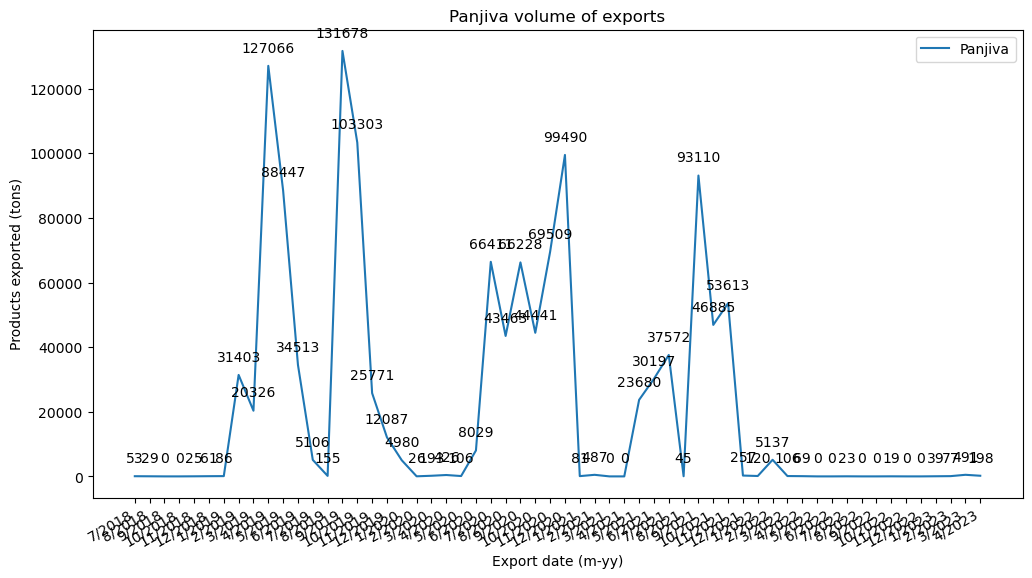

In [3]:
panjiva_g = cargo_grouping(panjiva, ["year", "month"], ["weight_ton"], ["year", "month"], True, {"weight_ton":"sum"})
panjiva_g["date"] = panjiva_g["month"].astype(str) + "/" + panjiva_g["year"].astype(str)
plot_line(panjiva_g["date"], [panjiva_g["weight_ton"]], ["Panjiva"], "Panjiva volume of exports", "Export date (m-yy)", "Products exported (tons)", False)

We plot the Panjiva and BSGI time series together in the same period (from August 2022 when the
BSGI started) to compare the trends from Panjiva and the BSGI more closely. There
seems to be a similar trend between the datasets from January 2023 onwards but
it's not very clear from the graph. There may be a lot of NAs in the export weights
from the Panjiva dataset.

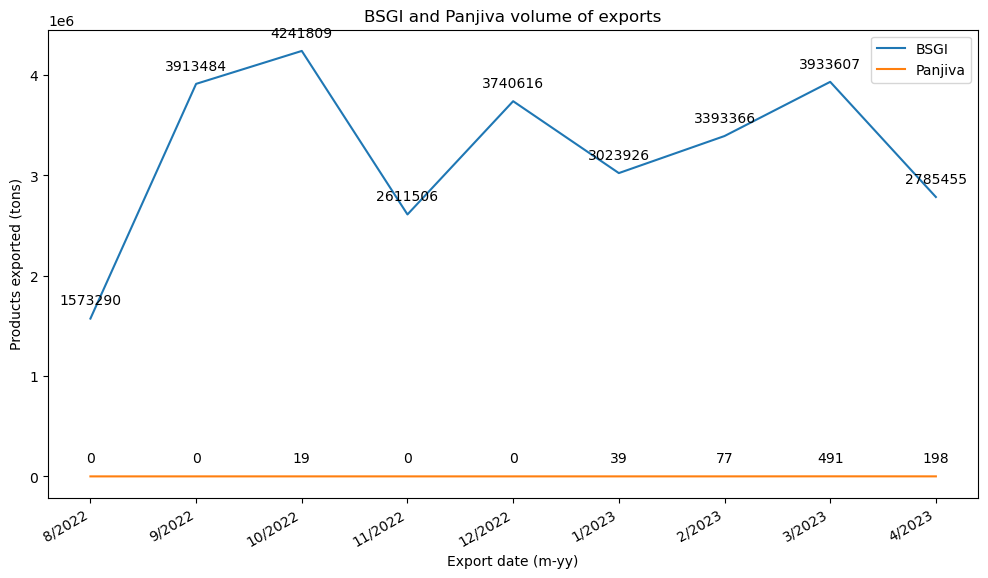

In [4]:
bsgi_g = cargo_grouping(bsgi, ["year", "month"], ["weight_ton"], ["year", "month"], True, {"weight_ton":"sum"})
bsgi_g["date"] = bsgi_g["month"].astype(str) + "/" + bsgi_g["year"].astype(str)

final = bsgi_g.merge(panjiva_g, on="date", suffixes=("_bsgi", "_panjiva"))
plot_line(final["date"], [final["weight_ton_bsgi"], final["weight_ton_panjiva"]], ["BSGI", "Panjiva"], "BSGI and Panjiva volume of exports", "Export date (m-yy)", "Products exported (tons)", False)

Let's check if the small export volume from January 2022 onwards is due to lack of data (NaN values) for weight of exports.

In [5]:
after_2022 = panjiva.loc[panjiva.loc[:, "date"] >= "2022-01-01"]

print("Number of NAs AFTER Jan 2022: ", sum(after_2022["weight_ton"].isna()))
print("Total observations: ", len(after_2022))
print("Share of NAs: ", round(sum(after_2022["weight_ton"].isna()) / len(after_2022) * 100, 2), "%")
print("Share of NAs: ", round(sum(after_2022["weight_ton"].isna()) / len(after_2022) * 100, 2), "%")

before_2022 = panjiva.loc[panjiva.loc[:, "date"] < "2022-01-01"]

print("Number of NAs BEFORE Jan 2022: ", sum(before_2022["weight_ton"].isna()))
print("Total observations: ", len(before_2022))
print("Share of NAs: ", round(sum(before_2022["weight_ton"].isna()) / len(before_2022) * 100, 2), "%")
print("Share of NAs: ", round(sum(before_2022["weight_ton"].isna()) / len(before_2022) * 100, 2), "%")

Number of NAs AFTER Jan 2022:  596
Total observations:  620
Share of NAs:  96.13 %
Share of NAs:  96.13 %
Number of NAs BEFORE Jan 2022:  1816
Total observations:  2085
Share of NAs:  87.1 %
Share of NAs:  87.1 %


We plot the NAs by month/year to see if there are more missing values since the
war started.

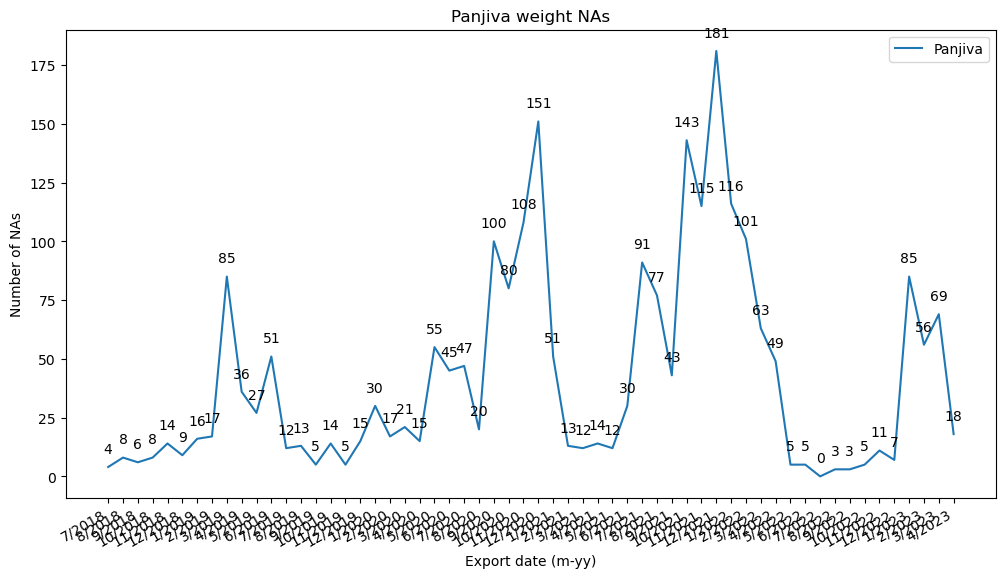

In [6]:
panjiva["na_bool"] = panjiva["weight_ton"].isna()
panjiva["na_bool"]

panjiva_g = cargo_grouping(panjiva, ["year", "month"], ["na_bool"], ["year", "month"], True, {"na_bool":"sum"})
panjiva_g["date"] = panjiva_g["month"].astype(str) + "/" + panjiva_g["year"].astype(str)
plot_line(panjiva_g["date"], [panjiva_g["na_bool"]], ["Panjiva"], "Panjiva weight NAs", "Export date (m-yy)", "Number of NAs", False)

We check the exports for September 2022, which has 0 volume exported in the graphs above, to see if it has missing values.

In [7]:
panjiva.loc[(panjiva.loc[:, "date"] > "2022-08-31") & (panjiva.loc[:, "date"] < "2022-10-01")][[ "date","weight_ton"]]

,date,weight_ton
8,2022-09-07,NaN
9,2022-09-06,NaN
66,2022-09-30,NaN


We do some record linkage between the Panjiva and BSGI datasets to see if we can merge some shipments.

In [8]:
bsgi = bsgi.rename(columns={"country_en": "country", "country": "country_uk"})
unique_matches = rl_ig_bsgi(panjiva, bsgi, "sunflower", ["date"], ["country"], ["date"])
unique_matches[["df_1", "df_2", "date_x", "date_y", "product_std", "country_x", "country_y", "weight_ton_x", "weight_ton_y"]]

Number of matches:  3


,df_1,df_2,date_x,date_y,product_std,country_x,country_y,weight_ton_x,weight_ton_y
0,626,659,2022-11-09,2022-11-09,sunflower,india,india,0.00,6010
1,645,394,2023-01-20,2023-01-20,sunflower,india,india,0.00,43000
2,664,313,2023-02-14,2023-02-14,sunflower,india,india,0.00,19176


We check if NAs are higher for certain companies.

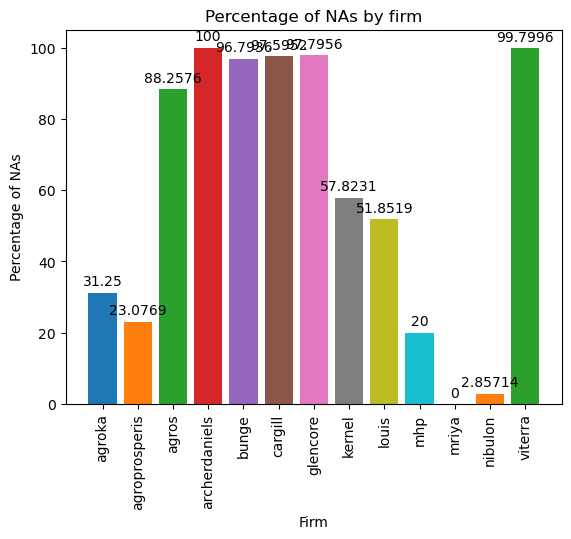

In [10]:
panjiva_g = cargo_grouping(panjiva, ["company_searched"], ["na_bool"], ["company_searched"], True, {"na_bool": ["sum", "count"]})
panjiva_g["na_boolpr"] = panjiva_g["na_boolsum"] / panjiva_g["na_boolcount"] * 100
plot_bar(panjiva_g["company_searched"], panjiva_g["na_boolpr"], "Firm", "Percentage of NAs", "Percentage of NAs by firm")

Now we do the same but we check if NAs are different for different countries of destination.

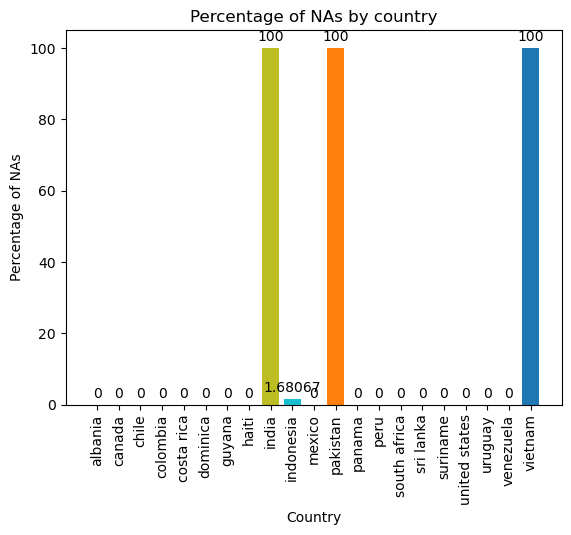

In [27]:
panjiva_g = cargo_grouping(panjiva, ["country"], ["na_bool"], ["country"], True, {"na_bool": ["sum", "count"]})
panjiva_g["na_boolpr"] = panjiva_g["na_boolsum"] / panjiva_g["na_boolcount"] * 100
plot_bar(panjiva_g["country"], panjiva_g["na_boolpr"], "Country", "Percentage of NAs", "Percentage of NAs by country")